In [767]:
import torch
from torch import nn

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

import pandas as pd

In [768]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [769]:
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 0],
    "Label": y
})
circles.head()

,X1,X2,Label
0,0.754246,0.754246,1
1,-0.756159,-0.756159,1
2,-0.815392,-0.815392,1
3,-0.393731,-0.393731,1
4,0.442208,0.442208,0


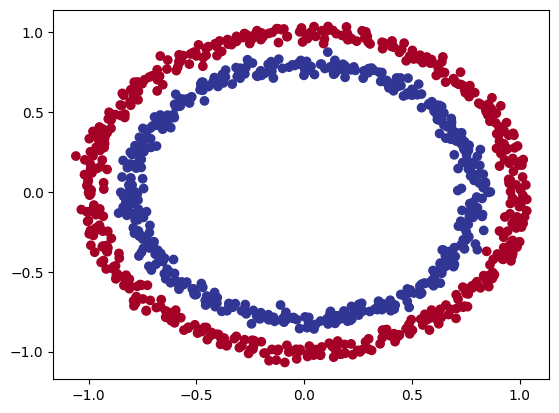

In [770]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [771]:
# Convert to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [772]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [773]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
    pred_data=None,
    pred_labels=None,
):
    plt.figure(figsize=(10, 7))

    if train_data is not None:
        train_data = train_data.cpu()
        train_labels = train_labels.cpu()
        plt.scatter(train_data[:,0], train_data[:,1], c=train_labels, s=10, cmap=plt.cm.RdYlBu, label="Train data")

    # test_data = test_data.cpu()
    # test_labels = test_labels.cpu()
    # plt.scatter(test_data[:,0], test_data[:,1], c=test_labels, s=10, cmap=plt.cm.PRGn, label="Train data")

    if predictions is not None:
        predictions = predictions.cpu()
    #     plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        plt.scatter(test_data[:,0], test_data[:,1], c=predictions, s=10, cmap=plt.cm.cool, label="Predictions")

    # if pred_data is not None and pred_labels is not None:
    #     pred_data = pred_data.cpu()
    #     pred_labels = pred_labels.cpu()
    #     plt.scatter(pred_data, pred_labels, c="black", s=4, label="Pred data 2")

    plt.legend(prop={"size": 14})

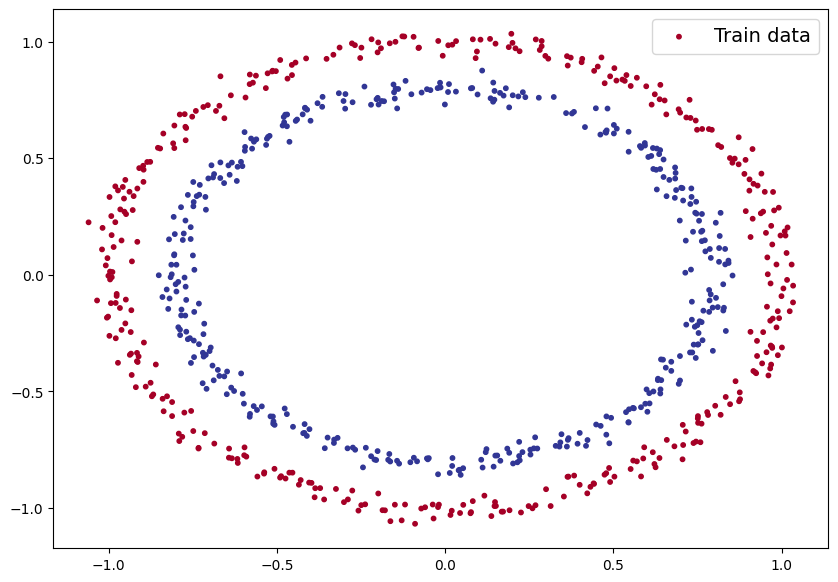

In [774]:
plot_predictions()

In [775]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = 'cpu'

In [776]:
class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)

    def forward(self, x):
        return self.layer_2(
            self.layer_1(
                x,
            )
        )

model_0 = CircleModelV0().to(device)

In [777]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [778]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
).to(device)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('2.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('2.bias', tensor([-0.1213]))])

In [779]:
with torch.inference_mode():
    non_train_pred = model_0(X_test.to(device))

print(len(y_train), len(y_test))
print(len(non_train_pred))
non_train_pred[:10]

750 250
250


tensor([[0.0202],
        [0.0098],
        [0.1209],
        [0.0302],
        [0.3008],
        [0.2996],
        [0.1330],
        [0.2077],
        [0.1121],
        [0.0114]])

In [780]:
non_train_pred_probs = torch.sigmoid(non_train_pred)
non_train_pred_probs[:10]

tensor([[0.5050],
        [0.5025],
        [0.5302],
        [0.5075],
        [0.5746],
        [0.5743],
        [0.5332],
        [0.5517],
        [0.5280],
        [0.5028]])

In [781]:
non_train_pred_probs = torch.round(torch.sigmoid(non_train_pred_probs))
non_train_pred_probs[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

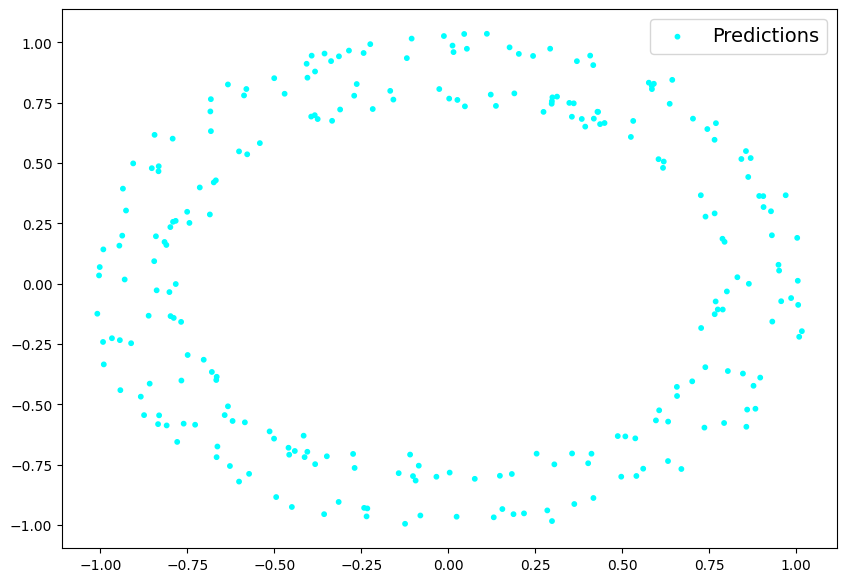

In [782]:
plot_predictions(
    train_data=None,
    predictions=non_train_pred_probs,
)

In [783]:
torch.vstack([non_train_pred[:5].squeeze(), y_test[:5]])

tensor([[0.0202, 0.0098, 0.1209, 0.0302, 0.3008],
        [1.0000, 0.0000, 1.0000, 0.0000, 1.0000]])

In [784]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1, momentum=0.9)

In [785]:
def accuracy_fn(y_true, y_pred):
    y_pred = y_pred.squeeze()
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true)) * 100
    return acc

In [786]:
accuracy_fn(y_test, non_train_pred_probs)

48.4

In [787]:
torch.manual_seed(42)

echo_count = []
loss_values = []
test_loss_values = []

epochs = 1000
epoch = 0

acc: 50.53333333333333
acc: 50.53333333333333
acc: 51.733333333333334
acc: 48.4
acc: 52.800000000000004
acc: 51.46666666666667
acc: 52.26666666666666
acc: 51.46666666666667
acc: 49.333333333333336
acc: 48.53333333333333
acc: 46.93333333333333
acc: 46.400000000000006
acc: 44.4
acc: 41.46666666666667
acc: 40.266666666666666
acc: 42.4
acc: 42.93333333333334
acc: 42.4
acc: 41.333333333333336
acc: 41.333333333333336
acc: 44.266666666666666
acc: 46.53333333333333
acc: 47.333333333333336
acc: 52.666666666666664
acc: 52.400000000000006
acc: 53.333333333333336
acc: 53.86666666666666
acc: 54.666666666666664
acc: 55.46666666666666
acc: 55.60000000000001
acc: 55.06666666666666
acc: 54.266666666666666
acc: 53.733333333333334
acc: 52.800000000000004
acc: 52.93333333333333
acc: 53.333333333333336
acc: 52.53333333333333
acc: 52.0
acc: 51.733333333333334
acc: 51.6
acc: 51.733333333333334
acc: 51.866666666666674
acc: 51.46666666666667
acc: 51.33333333333333
acc: 51.46666666666667
acc: 51.33333333333333


acc: 99.46666666666667
acc: 99.46666666666667
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.46666666666667
acc: 99.46666666666667
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.46666666666667
acc: 99.46666666666667
acc: 99.46666666666667
acc: 99.46666666666667
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.33333333333333
acc: 99.2
acc: 99.2
acc: 99.2
acc: 99.2
acc: 99.2
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99.06666666666666
acc: 99

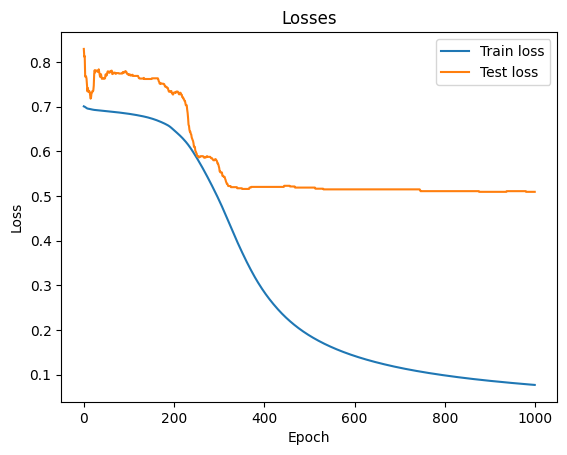

In [788]:
for i in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    print(f'acc: {acc}')

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_pred, y_test)

        echo_count.append(epoch)
        loss_values.append(loss.detach())
        test_loss_values.append(test_loss)
    
    epoch += 1

plt.plot(echo_count, loss_values, label="Train loss")
plt.plot(echo_count, test_loss_values, label="Test loss")
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [789]:
with torch.inference_mode():
    y_logits = model_0(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

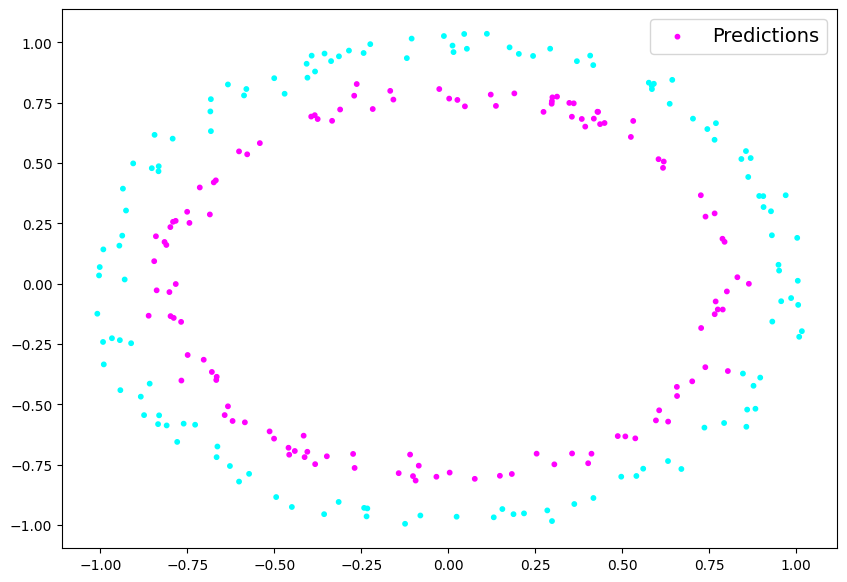

In [790]:
plot_predictions(
    train_data=None,
    predictions=y_pred,
)